# Anomaly Detection and Recommender Systems 

## 1 导入数据 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy import optimize as opt

In [2]:
mat = loadmat('./data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

In [4]:
def plotData(X, newFig=False):
    if newFig:
        plt.figure(figsize=(8, 6))
    plt.plot(X[:,0], X[:,1], 'b+')
    plt.xlabel('Latency [ms]', fontsize=16)
    plt.ylabel('Throughput [mb/s]', fontsize=16)
    plt.grid(True)


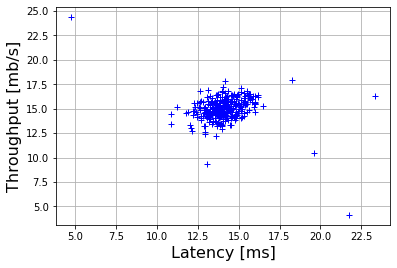

In [5]:
plotData(X)

## 2 高斯分布模型

In [104]:
def gausParams(X, useMultivarite=False):
    m = float(X.shape[0])
    mu = X.mean(axis=0)
    t = X - mu
    if not useMultivarite:
        sigma2 = np.sum(np.square(t), axis=0) / m
    else:
        sigma2 = (t.T @ t) / m
    return mu, sigma2

In [105]:
gausParams(X)

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([60.97489373, 53.20572186, 58.51546272, 84.20403725, 65.26859177,
        89.57487757, 55.63349911, 87.16233783, 29.62926829, 70.7852052 ,
        50.50356719]))

In [54]:
def gaus(X, m, sigma2):
    m, n = X.shape
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2)
    
    norm = 1. / (np.power(2 * np.pi, n / 2) * np.sqrt(np.linalg.det(sigma2)))
    inv = np.linalg.inv(sigma2)
    
    exp = np.zeros((m, 1))
    for row in range(m):
        xrow = X[row]
        exp[row] = np.exp(-0.5 * ((xrow - mu).T @ inv @ (xrow - mu)))
    return norm * exp

In [65]:
def plotContours(mu, sigma2, newFig=False, useMultivariate=True):
    delta = .5
    X = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(X, y)
    points = np.array([entry.ravel() for entry in (meshx, meshy)]).T
    z = gaus(points, mu, sigma2)
    z = z.reshape((X.shape[0], X.shape[0]))
    if newFig:
        plt.figure(figsize=(6, 4))
    cont_levels = [10**exp for exp in range(-20,0,3)]
    #[1e-20, 1e-17, 1e-14, 1e-11, 1e-08, 1e-05, 0.01]
    
    mycont = plt.contour(meshx, meshy, z, levels=cont_levels)
    plt.title('Gaussian Contours',fontsize=16)

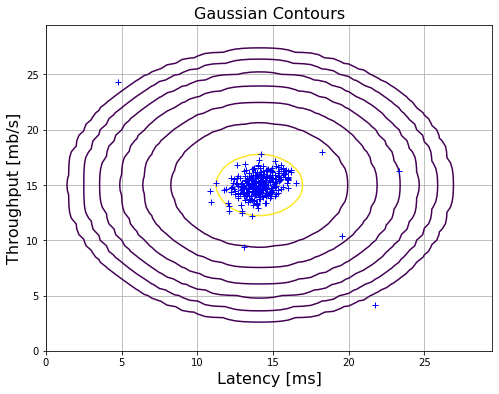

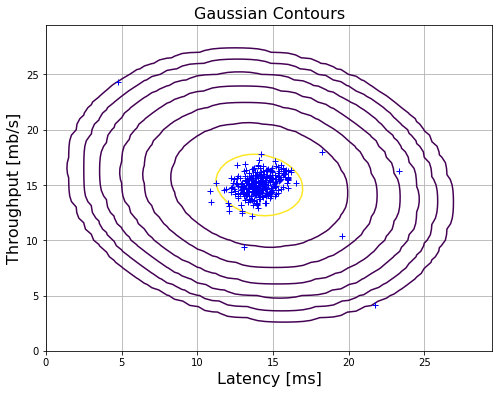

In [66]:
# First contours without using multivariate gaussian:
plotData(X, newFig=True)
useMV = False
plotContours(*gausParams(X, useMV), newFig=False, useMultivariate = useMV)

# Then contours with multivariate gaussian:
plotData(X, newFig=True)
useMV = True
plotContours(*gausParams(X, useMV), newFig=False, useMultivariate = useMV)

## 3 Selecting the threshold, ϵ

In [89]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    Precision = "of all predicted y=1, what fraction had true y=1"
    Recall = "of all true y=1, what fraction predicted y=1?
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    #print predVec.shape
    #print trueVec.shape
    #assert predVec.shape == trueVec.shape
    
    P, R = 0., 0.
    if float(np.sum(predVec)): #看清楚分子分母
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0]) if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0]) if trueVec[x]]) / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0

In [90]:
def selectThreshold(myycv, mypCVs):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.
    """
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(mypCVs),np.max(mypCVs),nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (myycv == 1).flatten()
    for eps in epses:
        predVec = mypCVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print("Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps))
    return bestF1, bestEps

In [91]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaus(Xval, mu, sigma2)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(yval,pCVs)

bestF1, bestEps

Best F1 is 0.875000, best eps is 9.075e-05.


(0.8750000000000001, 9.074844572965705e-05)

## 4 Plot the anomalies

In [92]:
def plotAnomalies(X, eps, newFig = False, useMultivariate = True):
    ps = gaus(X, *gausParams(X, useMultivariate))
    anoms = np.array([X[x] for x in range(X.shape[0]) if ps[x] < eps])
    if newFig: 
        plt.figure(figsize=(6,4))
    plt.scatter(anoms[:,0],anoms[:,1], s=80, facecolors='none', edgecolors='r')

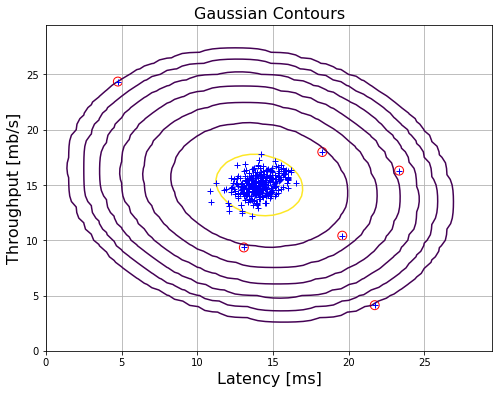

In [93]:
plotData(X, newFig=True)
plotContours(mu, sigma2, newFig=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFig=False, useMultivariate=True)

## 5 High dimensional dataset

In [94]:
mat = loadmat("./data/ex8data2.mat")
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [95]:
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

In [97]:
X.shape, Xval.shape, yval.shape

((1000, 11), (100, 11), (100, 1))

In [113]:
mu, sigma2 = gausParams(X, useMultivarite=False)
ps = gaus(X, mu, sigma2)

# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaus(Xval, mu, sigma2)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(yval,pCVs)
anoms = [X[x] for x in range(X.shape[0]) if ps[x] < bestEps]
print('# of anomalies found: ', len(anoms))

Best F1 is 0.615385, best eps is 1.379e-18.
# of anomalies found:  117
